<a href="https://colab.research.google.com/github/dam1412/weather_project/blob/main/Data_ThuDuc_predict_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta
import pytz
import joblib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(file_path):
  try:
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.lstrip()
    df.columns = df.columns.str.rstrip()
    df.index = pd.to_datetime(df.datetime)
    required_cols = ['temp', 'humidity', 'sealevelpressure','precipprob']
    df = df[required_cols]
    for col in df.columns:
      if df[col].isnull().any():
          print(f"⚠️ Warning: '{col}' have NaN!")
    # df['hour'] = df.index.hour
    return df
  except Exception as e:
    print(f"Error loading data: {e}")
    return pd.DataFrame()

In [ ]:
data_path= '/content/drive/MyDrive/Colab Notebooks/Train_data/Train_data_predict_future_2023_02_01_to_2025_04_01.csv'
data=load_data(data_path)
data.head()

,temp,humidity,sealevelpressure,precipprob
datetime,,,,
2023-02-01 00:00:00,26.0,83.56,1010.0,0
2023-02-01 01:00:00,25.8,84.49,1009.0,0
2023-02-01 02:00:00,25.0,88.68,1008.0,0
2023-02-01 03:00:00,24.0,94.15,1008.0,0
2023-02-01 04:00:00,24.9,89.00,1008.1,0


In [ ]:
def prepare_predict_future(data,feature):
    # required_columns = ['temp', 'humidity', 'sealevelpressure', 'hour']
    required_columns = ['temp', 'humidity', 'sealevelpressure']
    new_data = data[required_columns]
    future_steps = 5
    x = []
    y = []
    if feature=='temp':
      for i in range(len(new_data) - future_steps):
        seq = new_data.iloc[i].values  # Current time step
        label = new_data.iloc[i + 1:i + future_steps + 1, 0].values
        x.append(seq)
        y.append(label)
      x = np.array(x)
      y = np.array(y)
    elif feature=='hum':
      for i in range(len(new_data) - future_steps):
        seq = new_data.iloc[i].values  # Current time step
        label = new_data.iloc[i + 1:i + future_steps + 1, 1].values
        x.append(seq)
        y.append(label)
      x = np.array(x)
      y = np.array(y)
    else: print('error feature')
    return x,y


In [ ]:
def train_model_predict_future(x,y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  models = []
  mae_list = []
  rmse_list = []
  for i in range(5):
    model = XGBRegressor()
    model.fit(x_train, y_train[:, i])
    models.append(model)

    pred = model.predict(x_test)

    mae = mean_absolute_error(y_test[:, i], pred)
    mse = mean_squared_error(y_test[:, i], pred)
    rmse = np.sqrt(mse)

    print(f"\n Model + {i+1} hour:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    mae_list.append(mae)
    rmse_list.append(rmse)
  hours = np.arange(1, 6)
  plt.figure(figsize=(10, 6))
  plt.plot(hours, mae_list, marker='o', label='MAE', color='blue')
  plt.plot(hours, rmse_list, marker='s', label='RMSE', color='red')
  plt.title('MAE và RMSE theo từng giờ (+1h → +5h)', fontsize=14)
  plt.xlabel('Dự đoán + giờ', fontsize=12)
  plt.ylabel('ERROR', fontsize=12)
  plt.xticks(hours)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  return models


In [ ]:
API_KEY='c10735208c8617f07e9dadb5230018c5'
BASE_URL='https://api.openweathermap.org/data/2.5/' #base URL for making API request
def get_current_weather(city):
  url=f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric" #construct the API request URL
  response=requests.get(url) #send the get request to API
  data=response.json() #parse the response to JSON format
  # Check if the API call was successful
  if response.status_code != 200:
      print(f"Error fetching weather data for {city}: {data.get('message', 'Unknown error')}")
      return None  # Or raise an exception

  # Check if the 'name' key exists in the response
  if 'name' not in data:
      print(f"City '{city}' not found in the weather database.")
      return None  # Or raise an exception
  return {
      'city': data['name'],
      'current_temp':round(data['main']['temp']),
      # 'feels_like':round(data['main']['feels_like']),
      # 'temp_min':round(data['main']['temp_min']),
      # 'temp_max':round(data['main']['temp_max']),
      'humidity':round(data['main']['humidity']),
      # 'description':data['weather'][0]['description'],
      # 'country':data['sys']['country'],
      # 'wind_gust_dir':data['wind']['deg'],
      'pressure':data['main']['pressure'],
      # 'Wind_Gust_Speed':data['wind']['speed']
  }
city=input("Nhap city")
current_weather=get_current_weather(city)
current_data={
      'Humidity':current_weather['humidity'],
      'Pressure':current_weather['pressure'],
      'Temp':current_weather['current_temp']
  }
print(current_weather)

Nhap cityThu Duc
{'city': 'Thu Duc', 'current_temp': 35, 'humidity': 59, 'pressure': 1004}



 Model + 1 hour:
Mean Absolute Error (MAE): 0.7030415534973145
Mean Squared Error (MSE): 1.0070639274707043
Root Mean Squared Error (RMSE): 1.003525748284868

 Model + 2 hour:
Mean Absolute Error (MAE): 1.1492075974370959
Mean Squared Error (MSE): 2.3117892854968307
Root Mean Squared Error (RMSE): 1.5204569331279432

 Model + 3 hour:
Mean Absolute Error (MAE): 1.5360722698577463
Mean Squared Error (MSE): 3.9207553319505375
Root Mean Squared Error (RMSE): 1.9800897282574186

 Model + 4 hour:
Mean Absolute Error (MAE): 1.8314208396493572
Mean Squared Error (MSE): 5.320737469636858
Root Mean Squared Error (RMSE): 2.3066723802128593

 Model + 5 hour:
Mean Absolute Error (MAE): 2.050974295790002
Mean Squared Error (MSE): 6.596487522844707
Root Mean Squared Error (RMSE): 2.5683628098157603


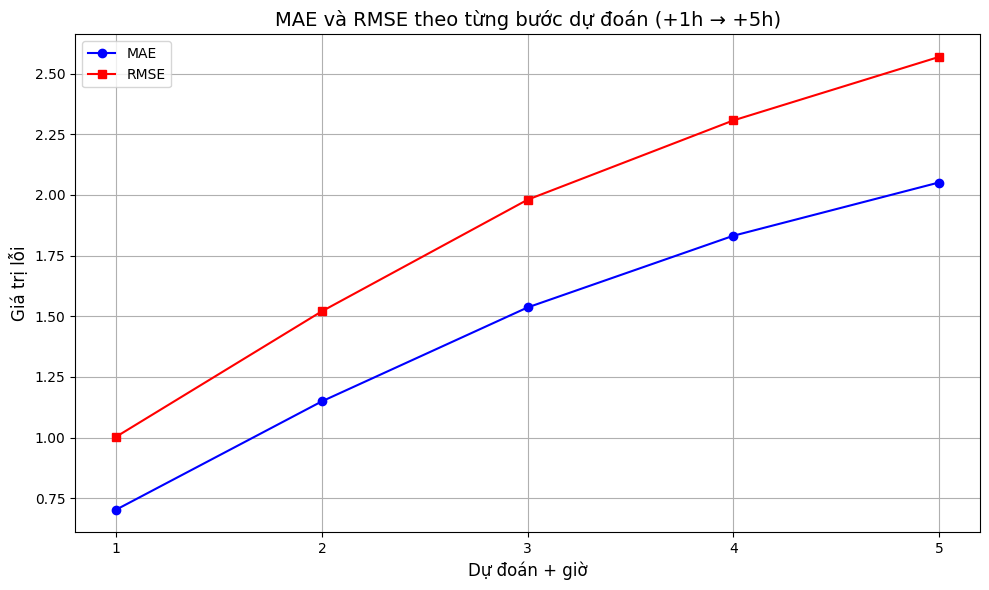


 temp + 1 hour:
[34.14727]

 temp + 2 hour:
[33.704994]

 temp + 3 hour:
[33.73733]

 temp + 4 hour:
[31.57713]

 temp + 5 hour:
[32.293823]

 Model + 1 hour:
Mean Absolute Error (MAE): 3.832479870377149
Mean Squared Error (MSE): 28.828892976769026
Root Mean Squared Error (RMSE): 5.3692544153512625

 Model + 2 hour:
Mean Absolute Error (MAE): 5.745633481571371
Mean Squared Error (MSE): 58.91181100699367
Root Mean Squared Error (RMSE): 7.675402986618597

 Model + 3 hour:
Mean Absolute Error (MAE): 7.51940227737668
Mean Squared Error (MSE): 95.60035843996918
Root Mean Squared Error (RMSE): 9.777543579037077

 Model + 4 hour:
Mean Absolute Error (MAE): 9.03271593148138
Mean Squared Error (MSE): 131.11294310236448
Root Mean Squared Error (RMSE): 11.450456021589904

 Model + 5 hour:
Mean Absolute Error (MAE): 10.029531636494355
Mean Squared Error (MSE): 157.61715595113932
Root Mean Squared Error (RMSE): 12.554567135156008


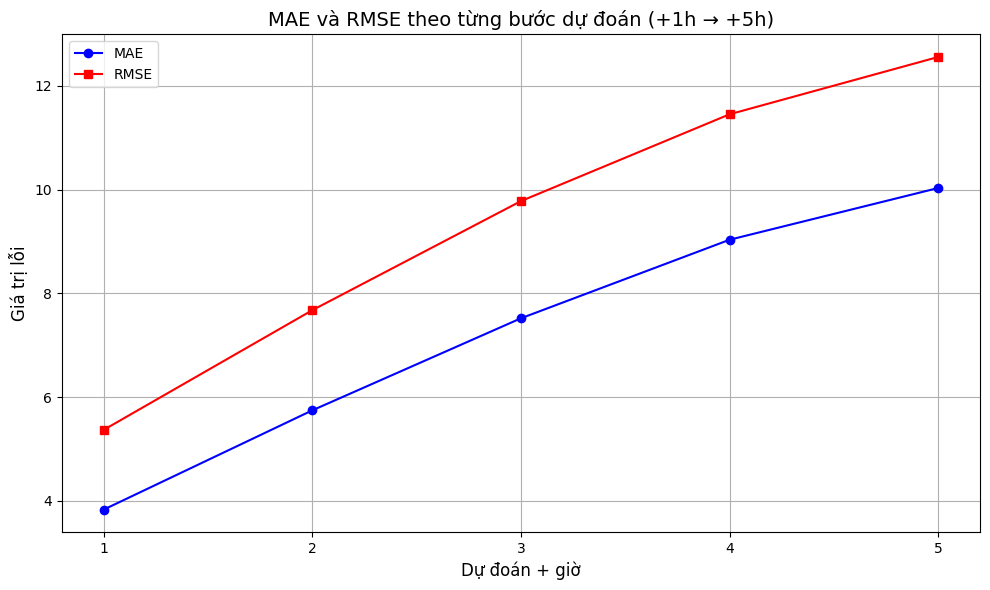


 hum + 1 hour:
[59.124504]

 hum + 2 hour:
[60.53089]

 hum + 3 hour:
[63.2672]

 hum + 4 hour:
[73.427795]

 hum + 5 hour:
[73.751366]


In [ ]:
x_temp,y_temp=prepare_predict_future(data,'temp')
model_temp=train_model_predict_future(x_temp,y_temp)
# predict
b=[34,60,1010]
b=np.array(b)
b=b.reshape(1,3)
i=0
for model in model_temp:
    pred = model.predict(b)
    i=i+1
    print(f"\n temp + {i} hour:")
    print(pred)
x_hum,y_hum=prepare_predict_future(data,'hum')
model_hum=train_model_predict_future(x_hum,y_hum)
# predict
b=[34,60,1010]
b=np.array(b)
b=b.reshape(1,3)
i=0
for model in model_hum:
    pred = model.predict(b)
    i=i+1
    print(f"\n hum + {i} hour:")
    print(pred)

In [ ]:
new_data_path='/content/drive/MyDrive/Colab Notebooks/Train_data/Train_data_rain_2019_01_01_to_2025_01_01(daily_csv).csv'
data_rain=load_data(new_data_path)
data_rain.head()

,temp,humidity,sealevelpressure,precipprob
datetime,,,,
2019-01-01,26.1,64.9,1012.3,100
2019-01-02,24.7,79.7,1011.8,100
2019-01-03,27.1,72.9,1011.9,100
2019-01-04,29.3,65.3,1012.5,100
2019-01-05,29.1,63.4,1012.4,0


In [ ]:
def prepare(data):
    required_columns = ['temp', 'humidity', 'sealevelpressure']
    X = data[required_columns]
    data['precipprob'] = data['precipprob'].replace(100,1)
    y = data['precipprob']
    return X, y
x_rain,y_rain=prepare(data_rain)

In [ ]:
def train_rain_model(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    return model
model_rain=train_rain_model(x_rain,y_rain)
b=[34,60,1010]
b=np.array(b)
b=b.reshape(1,3)
pred = model_rain.predict(b)[0]
rain_probability = "Yes" if pred == 1 else "No"
print(f"rain predict {rain_probability}")

Mean Squared Error: 0.15945330296127563
rain predict No


**Save model temp**

In [ ]:
model_dir='/content/drive/MyDrive/Colab Notebooks/Model_weather'
for i, model in enumerate(model_temp):
    model_path = os.path.join(model_dir, f"model_temp_{i+1}h.pkl")
    joblib.dump(model, model_path)



**Save model hum**

In [ ]:
model_dir='/content/drive/MyDrive/Colab Notebooks/Model_weather'
for i, model in enumerate(model_hum):
    model_path = os.path.join(model_dir, f"model_hum_{i+1}h.pkl")
    joblib.dump(model, model_path)


Save model rain

In [ ]:
model_dir='/content/drive/MyDrive/Colab Notebooks/Model_weather'
model_path = os.path.join(model_dir, "model_rain.pkl")
joblib.dump(model_rain, model_path)

['/content/drive/MyDrive/Colab Notebooks/Model_weather/model_rain.pkl']